In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d

In [6]:
wdir = os.getcwd()

hits_cols = "hit_id,x,y,z,volume_id,layer_id,module_id,event_name"
particle_cols = "particle_id,vx,vy,vz,px,py,pz,q,nhits,event_name"
truth_cols = "hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,event_name"
cells_cols = "hit_id,ch0,ch1,value,event_name"

hits_df = pd.DataFrame(columns = hits_cols.split(","))
particle_df = pd.DataFrame(columns=particle_cols.split(","))
truth_df =  pd.DataFrame(columns = truth_cols.split(","))
cells_df = pd.DataFrame(columns= cells_cols.split(','))

In [7]:
events2probe = ['event000001000','event000001001','event000001002','event000001003','event000001004']
fulldir = os.getcwd()+"/data/train_sample"
ctr = 1

for evnt in events2probe:
    fname = fulldir+"/"+evnt
    tmp = pd.read_csv(fname+'-hits.csv')
    tmp['event_name'] = evnt
    hits_df = pd.concat([hits_df,tmp],axis = 0)
    tmp = pd.read_csv(fname+'-truth.csv')
    tmp['event_name'] = evnt
    truth_df = pd.concat([truth_df,tmp],axis = 0)


In [8]:
df  = pd.merge(hits_df,truth_df,how = 'left', on = ['hit_id','event_name'])
df = df[df['particle_id']!= 0] # drop particle 0 
grouped = df.groupby(['event_name','particle_id'])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


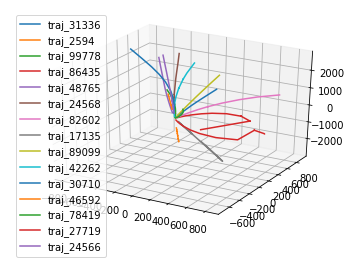

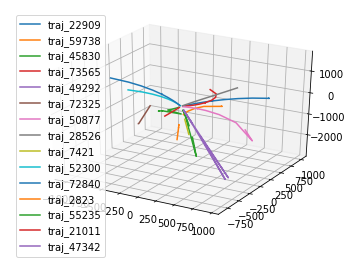

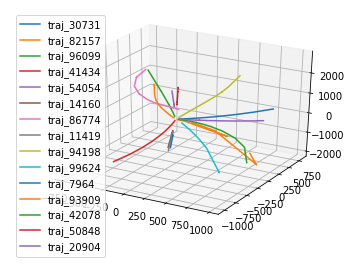

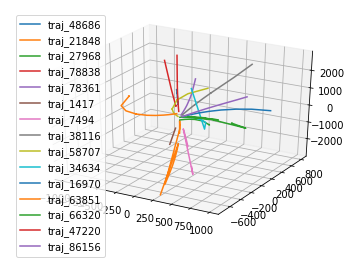

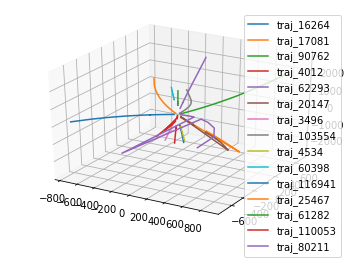

In [9]:
#  now plot the trajectory of several randomly chosen particles for each event
for event2plot in events2probe:
    # get all particles for that event except particle 0 since it exhibits strange behaviour !
    particles_ = df[(df['event_name'] == event2plot)]['particle_id'].values
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    legend = []
    for i in range(0,15):
        # select a particular group
        pid = np.random.randint(0,len(particles_))
        grp = grouped.get_group((event2plot,particles_[pid]))
        #now plot the group
        grp.sort_values('hit_id', inplace=True )
        ax.plot(grp.tx,grp.ty,grp.tz)
        legend.append('traj_'+str(pid))
    ax.legend(legend)
    # fig.savefig(event2plot+'_random_trajectories.png')

In [95]:
#  lets see the distribution of some metric for the curvature ... 
# 
#  !!! Numerical calculatoin of the trajectory curvature
#  the curvature at a point t for a reparametrized 3D curve
#  is propotional to |d^2r/dt^2|. Since we do not have time-stamps 
#  kappa ~ d^2r 
#  
def calc_curvature(data_fr):
    x = data_fr.tx
    y = data_fr.ty
    z = data_fr.tz
    ddx  = np.diff(np.diff(x))
    ddy  = np.diff(np.diff(y))
    ddz  = np.diff(np.diff(z))
#     take the mean curvature (not the sum) to avoid bias 
#     since some particles generate more hits and others less
    return np.sqrt(ddx**2 + ddy**2 + ddz**2).mean() 
    
#calculate the curvatures


In [96]:
curvatures = grouped.apply(calc_curvature)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
C:\Anaconda\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


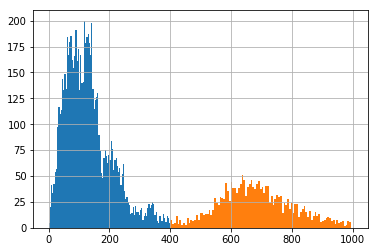

In [97]:
#plot a histogram
event000001000 = curvatures['event000001000']
event000001000.hist(bins = 100,range = [0,400])
event000001000.hist(bins = 100,range = [400,1000])

Now we see we have a majority of "slightly curved" trajectories and another population with a little
more complicated dynamics. Lets look at a trajectory from the centre of each 

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


89.37600086320391
621.9909277954133


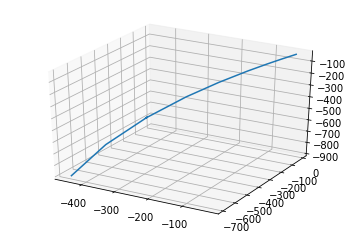

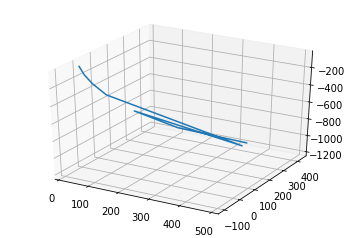

In [98]:
small_curvature_particles = event000001000[(event000001000.values > 80) & (event000001000.values < 120)]
large_curvature_particles = event000001000[(event000001000.values > 600) & (event000001000.values < 640)]

straight_p =  small_curvature_particles.index[np.random.randint(0,len(small_curvature_particles))]
curved_p = large_curvature_particles.index[np.random.randint(0,len(large_curvature_particles))]
                                        

traj1_ = df[(df['event_name'] == 'event000001000') & (df['particle_id']==straight_p)]
traj2_ = df[(df['event_name'] == 'event000001000') & (df['particle_id']==curved_p)]
print(str(small_curvature_particles[straight_p]))
fig = plt.figure()  
ax = plt.axes(projection = '3d')
ax.plot(traj1_.tx,traj1_.ty,traj1_.tz)

print(str(large_curvature_particles[curved_p]))
fig = plt.figure()  
ax = plt.axes(projection = '3d')
ax.plot(traj2_.tx,traj2_.ty,traj2_.tz)



In [76]:
df_2 = pd.merge(df,curvatures.reset_index(),how = 'left',left_on=['event_name','particle_id'],right_on=['event_name','particle_id'])

In [81]:
df_2.rename(columns={0:'curvature'},inplace=True)

In [84]:
df_2.to_csv('truth_n_curvatures.csv')